Epoch 1, Loss: 0.3056
Epoch 2, Loss: 0.1649
Epoch 3, Loss: 0.1693
Epoch 4, Loss: 0.1559
Epoch 5, Loss: 0.1475


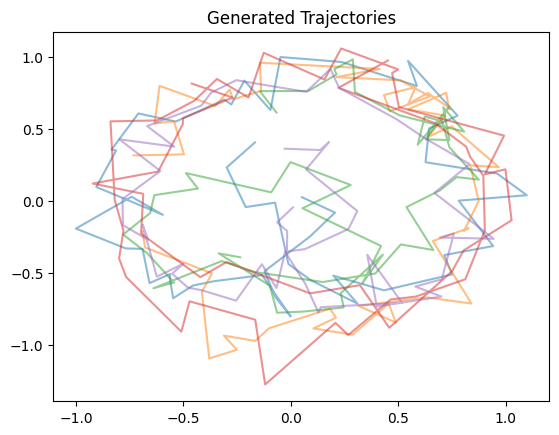

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
import matplotlib.pyplot as plt

# 随机种子设置
torch.manual_seed(42)
np.random.seed(42)

# --------------------
# 1. 轨迹数据模拟与预处理
# --------------------
class SyntheticTrajectoryDataset(Dataset):
    """生成正弦波+噪声的模拟轨迹数据"""
    def __init__(self, num_samples=1000, seq_len=50):
        self.num_samples = num_samples
        self.seq_len = seq_len
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # 生成基础正弦轨迹
        t = np.linspace(0, 2*np.pi, self.seq_len)
        x = np.sin(t) + 0.1 * np.random.randn(self.seq_len)
        y = np.cos(t) + 0.1 * np.random.randn(self.seq_len)
        
        # 合并为 (seq_len, 2) 的轨迹
        traj = np.stack([x, y], axis=-1).astype(np.float32)
        return torch.from_numpy(traj)

# 数据参数
SEQ_LEN = 50  # 轨迹长度
INPUT_DIM = 2  # (x,y)坐标

# 创建数据集
dataset = SyntheticTrajectoryDataset(num_samples=1000, seq_len=SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# --------------------
# 2. 扩散模型核心组件
# --------------------
class SinusoidalEmbedding(nn.Module):
    """时间步的位置编码"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = np.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class TrajectoryDenoiser(nn.Module):
    """去噪网络：1D U-Net结构"""
    def __init__(self, input_dim=INPUT_DIM, dim=128):
        super().__init__()
        self.dim = dim
        
        # 时间嵌入
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(dim),
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim))
        
        # 下采样
        self.down1 = nn.Sequential(
            nn.Conv1d(input_dim, dim, 3, padding=1),
            nn.GroupNorm(4, dim),
            nn.GELU())
        
        self.down2 = nn.Sequential(
            nn.Conv1d(dim, dim*2, 3, stride=2, padding=1),  # 长度减半
            nn.GroupNorm(8, dim*2),
            nn.GELU())
        
        # 中间层
        self.mid = nn.Sequential(
            nn.Conv1d(dim*2, dim*2, 3, padding=1),
            nn.GroupNorm(8, dim*2),
            nn.GELU())
        
        # 上采样
        self.up1 = nn.Sequential(
            nn.ConvTranspose1d(dim*2, dim, 4, stride=2, padding=1),  # 长度恢复
            nn.GroupNorm(4, dim),
            nn.GELU())
        
        self.up2 = nn.Sequential(
            nn.Conv1d(dim*2, dim, 3, padding=1),
            nn.GroupNorm(4, dim),
            nn.GELU(),
            nn.Conv1d(dim, input_dim, 1))  # 输出与输入同维度
        
    def forward(self, x, t):
        # x: (batch, seq_len, input_dim)
        x = rearrange(x, 'b l d -> b d l')  # 转为通道优先

        self.time_proj = nn.Linear(self.dim, self.dim * 2)  # Use self.dim

        # Modify the forward method to use the projection
        t_emb = self.time_mlp(t)
        t_emb = rearrange(t_emb, 'b d -> b d 1')  # Expand to match feature map dimensions
        t_emb_proj = self.time_proj(t_emb.squeeze(-1)).unsqueeze(-1)  # Project to match h2's channel size

        # Downsampling path
        h1 = self.down1(x) + t_emb  # (b, dim, l)
        h2 = self.down2(h1) + t_emb_proj  # (b, dim*2, l//2)

        # # 时间嵌入
        # t_emb = self.time_mlp(t)
        # t_emb = rearrange(t_emb, 'b d -> b d 1')  # 扩增到与特征图相同维度
        
        # # 下采样路径
        # h1 = self.down1(x) + t_emb  # (b, dim, l)
        # h2 = self.down2(h1) + t_emb  # (b, dim*2, l//2)
        
        # 中间层
        h = self.mid(h2)
        
        # 上采样路径
        h = self.up1(h)
        h = torch.cat([h, h1], dim=1)  # Skip Connection
        h = self.up2(h)
        
        return rearrange(h, 'b d l -> b l d')

# --------------------
# 3. 扩散过程工具函数
# --------------------
def linear_beta_schedule(timesteps):
    """线性噪声调度"""
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def forward_diffusion(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """前向扩散过程：q(x_t | x_0)"""
    noise = torch.randn_like(x0)
    sqrt_alpha = sqrt_alphas_cumprod[t].reshape(-1, 1, 1)
    sqrt_one_minus_alpha = sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1)
    return sqrt_alpha * x0 + sqrt_one_minus_alpha * noise, noise

# 定义扩散参数
TIMESTEPS = 200
betas = linear_beta_schedule(TIMESTEPS)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# --------------------
# 4. 训练循环
# --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TrajectoryDenoiser().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch():
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        
        # 随机采样时间步
        t = torch.randint(0, TIMESTEPS, (batch.size(0),), device=device)
        
        # 前向扩散
        noisy_traj, noise = forward_diffusion(
            batch, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        
        # 噪声预测
        pred_noise = model(noisy_traj, t)
        
        # 损失计算
        loss = nn.functional.mse_loss(pred_noise, noise)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# 训练5个epoch
for epoch in range(5):
    loss = train_epoch()
    print(f'Epoch {epoch+1}, Loss: {loss:.4f}')

# --------------------
# 5. 轨迹生成（采样）
# --------------------
@torch.no_grad()
def sample(num_samples=1):
    """从随机噪声开始逐步去噪"""
    model.eval()
    
    # 初始噪声
    x = torch.randn((num_samples, SEQ_LEN, INPUT_DIM), device=device)
    
    for t in reversed(range(TIMESTEPS)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)
        pred_noise = model(x, t_tensor)
        
        alpha_t = alphas[t].reshape(-1, 1, 1)
        alpha_cumprod_t = alphas_cumprod[t].reshape(-1, 1, 1)
        beta_t = betas[t].reshape(-1, 1, 1)
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        # 逆向扩散步
        x = (1 / torch.sqrt(alpha_t)) * (
            x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
        ) + torch.sqrt(beta_t) * noise
    
    return x.cpu()

# 生成5条轨迹并可视化
generated = sample(5)
for i in range(5):
    plt.plot(generated[i, :, 0], generated[i, :, 1], alpha=0.5)
plt.title('Generated Trajectories')
plt.show()